# Comparaison LSTM : Dataset Standard vs Dataset Enrichi

## Objectifs de ce notebook

Dans ce notebook, nous allons comparer les performances d'un modèle LSTM entraîné sur deux datasets différents :

1. **Dataset Standard** : Contient uniquement "Titre de l'opération"
2. **Dataset Enrichi** : Contient "Titres opération et projet lauréat" (concaténation enrichie)

L'objectif est de déterminer si l'enrichissement du corpus textuel améliore les performances du modèle.

## 1. Imports et Configuration Dataset léger

In [46]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import pickle
import json
# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
# KerasNLP pour BERT
import keras_nlp
# Sklearn pour métriques
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f" GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\n TensorFlow version: {tf.__version__}")
print(f" Keras version: {keras.__version__}")
print(f" KerasNLP version: {keras_nlp.__version__}")
print(f" Backend: {keras.backend.backend()}")


  Aucun GPU détecté - Utilisation du CPU

 TensorFlow version: 2.20.0
 Keras version: 3.10.0
 KerasNLP version: 0.21.1
 Backend: tensorflow


#### Chargement du dataset et traitement des cellules manquantes

In [47]:
# Télécharger le dataset csv et l'afficher
print(" Chargement du dataset CSV...\n")

# Charger le CSV
df = pd.read_csv('data/dataset-for-training.csv')

print(f" Dataset chargé : {len(df)} lignes")
print(f"\nColonnes : {list(df.columns)}")
print(f"\n Aperçu des données :")
print(df.head())

# Nettoyer les données : supprimer les lignes avec des valeurs manquantes
print(f"\n Nettoyage des données...")
print(f"Lignes avec valeurs manquantes : {df.isnull().sum().sum()}")
df = df.dropna()

# Nettoyer les thématiques : supprimer les lignes avec thématiques vides ou invalides
df['Thématique'] = df['Thématique'].str.strip()  # Supprimer espaces
df = df[df['Thématique'].str.len() > 0]  # Supprimer thématiques vides
df = df[~df['Thématique'].str.match(r'^[\W_]+$')]  # Supprimer thématiques avec seulement des caractères spéciaux

print(f" Après nettoyage : {len(df)} lignes")

# Statistiques des thématiques
print(f"\n Distribution des thématiques :")
thematic_counts = df['Thématique'].value_counts()
print(thematic_counts)
print(f"\nNombre de thématiques uniques : {df['Thématique'].nunique()}")

 Chargement du dataset CSV...

 Dataset chargé : 5102 lignes

Colonnes : ["Titre de l'opération", 'Thématique']

 Aperçu des données :
                                Titre de l'opération             Thématique
0           Art urbain quartier des impressionnistes           Cadre de vie
1     Des bancs pour les écoles du boulevard Pereire  Education et jeunesse
2  Des lanternes pour le quartier historique du 2...           Cadre de vie
3  Cour de récréation école élémentaire La Motte ...  Education et jeunesse
4  Installer des espaces de convivialité aux Butt...           Cadre de vie

 Nettoyage des données...
Lignes avec valeurs manquantes : 5
 Après nettoyage : 5097 lignes

 Distribution des thématiques :
Thématique
Education et jeunesse     1404
Environnement              967
Cadre de vie               754
Solidarités                590
Culture et patrimoine      340
Sport                      334
Propreté                   308
Attractivité et emploi     141
Mobilités               

#### Nettoyage du corpus texte

In [48]:
# Nettoyage du texte français
def preprocess_text(text):
    """Normalisation du texte français"""
    text = text.lower()
    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüÿœ'\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

print(" Nettoyage des titres de projets...\n")
# AVANT 
print(df['Titre de l\'opération'].head(20))
# Appliquer le preprocessing sur la colonne "Titre de l'opération"
df['Titre de l\'opération'] = df['Titre de l\'opération'].apply(preprocess_text)

# APRES
print(" Titres nettoyés !")
print(f"\n Exemples de titres nettoyés :")
print(df['Titre de l\'opération'].head(20))

 Nettoyage des titres de projets...

0              Art urbain quartier des impressionnistes
1        Des bancs pour les écoles du boulevard Pereire
2     Des lanternes pour le quartier historique du 2...
3     Cour de récréation école élémentaire La Motte ...
4     Installer des espaces de convivialité aux Butt...
5                        Continuité cyclable rue Riquet
6              Piétonnisation du quartier Saint-Séverin
7              Rénovation de la sous-dalle Beaugrenelle
8                    Remise en état horloge St Ambroise
9       Rénover les aménagements de la rue Jeanne-d’Arc
10                            Cultiver au Champ de Mars
11    Les Petits Maraîchers - potagers pédagogiques ...
12                                Fresque rue Broca 1/2
13                      Playground du jardin des Halles
14    Parcours végétal et artistique entre Montmartr...
15                Réfectoire école maternelle BESSIERES
16    Végétaliser les trottoirs du 15ème / 01- Gerbe...
17         

#### Encodage des labels et sauvegarde de la clé de traduction

In [49]:
# Encoder les thématiques (string) en entiers AVANT la séparation
print(" Encodage des thématiques en entiers...\n")

# Créer l'encodeur
label_encoder = LabelEncoder()

# Fit sur TOUTES les thématiques du dataset
label_encoder.fit(df['Thématique'])

# Transformer toutes les thématiques
y_all_encoded = label_encoder.transform(df['Thématique'])

# Nombre de classes
num_classes = len(label_encoder.classes_)

print(f" Encodage terminé !")
print(f"\n Nombre de classes : {num_classes}")
print(f"\n  Mapping des thématiques (10 premières) :")
for idx, thematic in enumerate(label_encoder.classes_[:10]):
    print(f"   {idx} → {thematic}")

if num_classes > 10:
    print(f"   ... et {num_classes - 10} autres thématiques")

# Note : La sauvegarde du mapping et tokenizer sera faite à la fin du notebook
# après avoir déterminé quel dataset (standard ou enrichi) est le meilleur

print(f"\n Exemple :")
print(f"   Thématique originale : '{df['Thématique'].iloc[0]}'")
print(f"   Thématique encodée   : {y_all_encoded[0]}")


 Encodage des thématiques en entiers...

 Encodage terminé !

 Nombre de classes : 11

  Mapping des thématiques (10 premières) :
   0 → Attractivité et emploi
   1 → Cadre de vie
   2 → Culture et patrimoine
   3 → Education et jeunesse
   4 → Environnement
   5 → Mobilités
   6 → Propreté
   7 → Prévention et sécurité
   8 → Santé
   9 → Solidarités
   ... et 1 autres thématiques

 Exemple :
   Thématique originale : 'Cadre de vie'
   Thématique encodée   : 1


#### Séparation des jeux de test/train/validation

In [50]:
print(f" Séparation des données...\n")

# Extraire X (textes) et y (thématiques ENCODÉES)
X_all = df['Titre de l\'opération'].values
y_all = y_all_encoded  # Utiliser les labels encodés

print(f"Nombre total de projets : {len(X_all)}")
print(f"Nombre de thématiques uniques : {num_classes}")

# Séparation 70% train / 30% test (stratifié pour garder la distribution des thématiques)
X_train_all_text, X_test_text, y_train_all, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=SEED, stratify=y_all
)

# Créer un validation set (20% du train)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_all_text, y_train_all, test_size=0.2, random_state=SEED, stratify=y_train_all
)

print(f"\n Préparation terminée !")
print(f"\n Répartition finale:")
print(f"   Train: {len(X_train_text):,} projets ({len(X_train_text)/len(df)*100:.1f}%)")
print(f"   Validation: {len(X_val_text):,} projets ({len(X_val_text)/len(df)*100:.1f}%)")
print(f"   Test: {len(X_test_text):,} projets ({len(X_test_text)/len(df)*100:.1f}%)")

print(f"\n Exemple de projet :")
print(f"Titre : {X_train_text[0]}")
print(f"Thématique (encodée) : {y_train[0]}")
print(f"Thématique (décodée) : {label_encoder.inverse_transform([y_train[0]])[0]}")

# Statistiques de longueur (convertir en str pour éviter les erreurs)
train_lengths = [len(str(text).split()) for text in X_train_text]
print(f"\n Longueur moyenne des titres: {np.mean(train_lengths):.1f} mots")
print(f" Longueur min: {np.min(train_lengths)} mots")
print(f" Longueur max: {np.max(train_lengths)} mots")

 Séparation des données...

Nombre total de projets : 5097
Nombre de thématiques uniques : 11

 Préparation terminée !

 Répartition finale:
   Train: 2,853 projets (56.0%)
   Validation: 714 projets (14.0%)
   Test: 1,530 projets (30.0%)

 Exemple de projet :
Titre : auvent groupe scolaire ampere
Thématique (encodée) : 3
Thématique (décodée) : Education et jeunesse

 Longueur moyenne des titres: 6.9 mots
 Longueur min: 1 mots
 Longueur max: 46 mots


In [51]:
# Note : y_train, y_val et y_test sont déjà encodés (entiers)
# Pas besoin de transformation supplémentaire

print(" Les labels sont déjà encodés en entiers")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_val shape: {y_val.shape}")
print(f"   y_test shape: {y_test.shape}")
print(f"\n   Nombre de classes : {num_classes}")

 Les labels sont déjà encodés en entiers
   y_train shape: (2853,)
   y_val shape: (714,)
   y_test shape: (1530,)

   Nombre de classes : 11


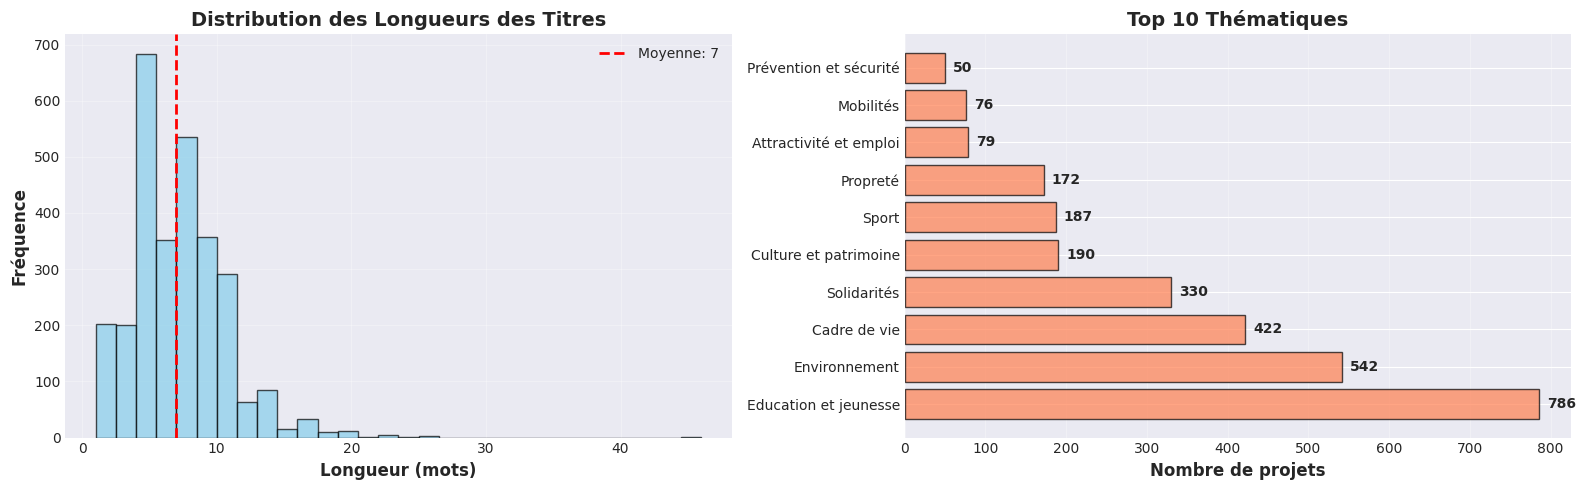


 Total de thématiques uniques: 11
 Thématique la plus fréquente: 'Education et jeunesse' (786 projets)


In [52]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Distribution des longueurs
ax1.hist(train_lengths, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(train_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(train_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs des Titres', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution des thématiques (décoder pour l'affichage)
y_train_decoded = label_encoder.inverse_transform(y_train)
thematic_counts = pd.Series(y_train_decoded).value_counts()
top_thematics = thematic_counts.head(10)  # Top 10 thématiques

ax2.barh(range(len(top_thematics)), top_thematics.values, color='coral', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(top_thematics)))
ax2.set_yticklabels(top_thematics.index, fontsize=10)
ax2.set_xlabel('Nombre de projets', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Thématiques', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, count in enumerate(top_thematics.values):
    ax2.text(count + 10, i, f'{count}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Total de thématiques uniques: {len(thematic_counts)}")
print(f" Thématique la plus fréquente: '{top_thematics.index[0]}' ({top_thematics.values[0]} projets)")

### 2.1 Exemples de Projets

In [53]:
# Afficher des exemples de différentes thématiques
print("\n" + "=" * 80)
print(" " * 25 + " EXEMPLES DE PROJETS")
print("=" * 80)

# Prendre des exemples de différentes thématiques (décoder pour l'affichage)
y_train_decoded = label_encoder.inverse_transform(y_train)
unique_thematics = pd.Series(y_train_decoded).unique()[:11]  # 10 premières thématiques

for thematic in unique_thematics:
    indices = np.where(y_train_decoded == thematic)[0][:3]  # 3 exemples par thématique
    
    print(f"\n  Thématique: {thematic}")
    print("-" * 80)
    
    for idx in indices:
        titre = X_train_text[idx]
        print(f"  • {titre} ({len(titre.split())} mots)")
    
    print(f"  → Total: {len(np.where(y_train_decoded == thematic)[0])} projets dans cette thématique")


                          EXEMPLES DE PROJETS

  Thématique: Education et jeunesse
--------------------------------------------------------------------------------
  • auvent groupe scolaire ampere (4 mots)
  • rénovation de l'aire de jeux des jardins du trocadéro (9 mots)
  • collège george sand (3 mots)
  → Total: 786 projets dans cette thématique

  Thématique: Cadre de vie
--------------------------------------------------------------------------------
  • poursuivre la coulée verte à beaugrenelle de la rue caillavet à la rue du théatre (15 mots)
  • des tables de jeux d'échecs au parc monceau (8 mots)
  • des fontaines à boire dans tout paris fontaine arceau (9 mots)
  → Total: 422 projets dans cette thématique

  Thématique: Solidarités
--------------------------------------------------------------------------------
  • avenir (1 mots)
  • achat de vélos cargos et de matériel (7 mots)
  • aider les personnes fragiles à s'intégrer durablement (7 mots)
  → Total: 330 projets dans 

## Tokenization pour LSTM (dataset léger)

In [54]:
# Configuration
MAX_WORDS = 10000
MAX_LEN = 46

# Tokenizer
tokenizer_lstm = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer_lstm.fit_on_texts(X_train_text)

# Séquences
X_train_seq = tokenizer_lstm.texts_to_sequences(X_train_text)
X_val_seq = tokenizer_lstm.texts_to_sequences(X_val_text)
X_test_seq = tokenizer_lstm.texts_to_sequences(X_test_text)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print(f" Tokenization terminée !")
print(f"\n Shapes: Train {X_train_pad.shape}, Val {X_val_pad.shape}, Test {X_test_pad.shape}")

 Tokenization terminée !

 Shapes: Train (2853, 46), Val (714, 46), Test (1530, 46)


### 3.2 Architecture et Entraînement LSTM

In [55]:
def creer_modele_lstm(vocab_size, max_len, embedding_dim=128, lstm_units=64):
    """
    Crée un modèle LSTM bidirectionnel pour la classification de texte.
    
    Args:
        vocab_size: Taille du vocabulaire
        max_len: Longueur maximale des séquences
        embedding_dim: Dimension des embeddings (default: 128)
        lstm_units: Nombre d'unités LSTM (default: 64)
    """
    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
        layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(lstm_units)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

lstm_model = creer_modele_lstm(MAX_WORDS, MAX_LEN)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(" Modèle LSTM créé !\n")
lstm_model.summary()

 Modèle LSTM créé !



Model: "sequential_3"

 Layer (type)                     Output Shape                  Param # 

 embedding_3 (Embedding)          ?                         0 (unbuilt) 

 bidirectional_6 (Bidirectional)  ?                         0 (unbuilt) 

 dropout_9 (Dropout)              ?                                   0 

 bidirectional_7 (Bidirectional)  ?                         0 (unbuilt) 

 dropout_10 (Dropout)             ?                                   0 

 dense_6 (Dense)                  ?                         0 (unbuilt) 

 dropout_11 (Dropout)             ?                                   0 

 dense_7 (Dense)                  ?                         0 (unbuilt)

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [56]:
# Entraînement
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(" Entraînement LSTM...\n")
history_lstm = lstm_model.fit(
    X_train_pad, y_train,  # y_train est déjà encodé
    validation_data=(X_val_pad, y_val),  # y_val est déjà encodé
    epochs=10,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

print("\n Entraînement LSTM terminé !")

 Entraînement LSTM...

Epoch 1/10
Epoch 1/10
45/45  7s 74ms/step - accuracy: 0.2042 - loss: 2.2276 - val_accuracy: 0.3137 - val_loss: 1.9771
Epoch 2/10
45/45  7s 74ms/step - accuracy: 0.2042 - loss: 2.2276 - val_accuracy: 0.3137 - val_loss: 1.9771
Epoch 2/10
45/45  3s 68ms/step - accuracy: 0.3410 - loss: 1.9248 - val_accuracy: 0.5252 - val_loss: 1.4431
Epoch 3/10
45/45  3s 68ms/step - accuracy: 0.3410 - loss: 1.9248 - val_accuracy: 0.5252 - val_loss: 1.4431
Epoch 3/10
45/45  3s 68ms/step - accuracy: 0.5509 - loss: 1.3548 - val_accuracy: 0.5868 - val_loss: 1.2690
Epoch 4/10
45/45  3s 68ms/step - accuracy: 0.5509 - loss: 1.3548 - val_accuracy: 0.5868 - val_loss: 1.2690
Epoch 4/10
45/45  3s 60ms/step - accuracy: 0.6641 - loss: 1.0466 - val_accuracy: 0.6092 - val_loss: 1.1977
Epoch 5/10
45/45  3s 60ms/step - accuracy: 0.6641 - loss: 1.0466 - val_accuracy: 0.6092 - val_loss: 1.1977
Epoch 5/10
45/45  3s 66ms/step - accuracy: 0.7189 - loss: 0.8728 - val_accuracy: 0.6331 - val_loss: 1.2144
Epo

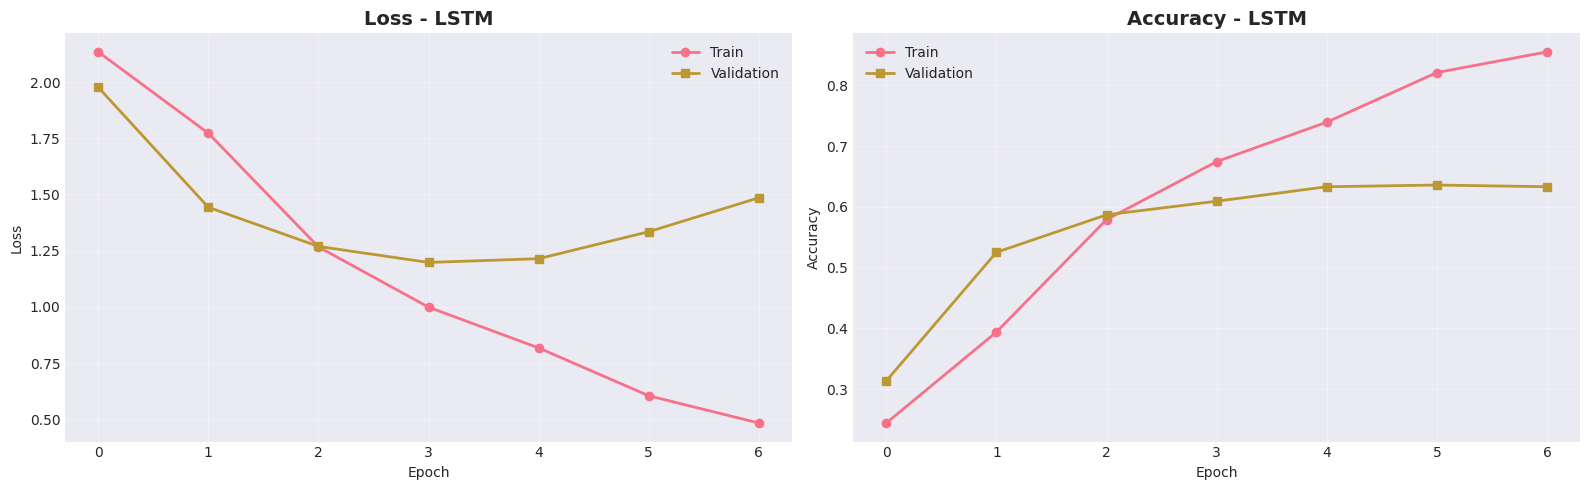

In [57]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(history_lstm.history['loss'], label='Train', linewidth=2, marker='o')
ax1.plot(history_lstm.history['val_loss'], label='Validation', linewidth=2, marker='s')
ax1.set_title('Loss - LSTM', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history_lstm.history['accuracy'], label='Train', linewidth=2, marker='o')
ax2.plot(history_lstm.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
ax2.set_title('Accuracy - LSTM', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Évaluation LSTM

In [58]:
# Évaluation
test_loss, test_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad, verbose=0), axis=1)

print("\n PERFORMANCES LSTM")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("\n Classification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))


 PERFORMANCES LSTM
Test Loss: 1.2443
Test Accuracy: 0.5935 (59.35%)

 Classification Report:
                        precision    recall  f1-score   support

Attractivité et emploi       0.00      0.00      0.00        42
          Cadre de vie       0.37      0.77      0.50       226
 Culture et patrimoine       0.00      0.00      0.00       102
 Education et jeunesse       0.92      0.83      0.87       422
         Environnement       0.81      0.66      0.73       290
             Mobilités       0.00      0.00      0.00        41
              Propreté       0.98      0.60      0.75        93
Prévention et sécurité       0.00      0.00      0.00        26
                 Santé       0.00      0.00      0.00        11
           Solidarités       0.38      0.68      0.49       177
                 Sport       0.25      0.14      0.18       100

              accuracy                           0.59      1530
             macro avg       0.34      0.34      0.32      1530
        

### Tests sur Nouvelles Reviews

In [59]:
# Titres de test (en français pour correspondre au dataset)
test_titles = [
    "alimentation biologique à la cantine ",
    "installation de panneaux solaires sur les bâtiments publics",
    "rénovation de la bibliothèque municipale",
    "organisation d'ateliers culturels pour les jeunes",
    "aménagement d'une piste cyclable sécurisée",
    "développement d'un jardin partagé communautaire",
]

print("\n" + "=" * 90)
print(" " * 20 + " PRÉDICTIONS LSTM SUR NOUVEAUX TITRES DE PROJETS")
print("=" * 90)

# Tokenizer les titres avec le tokenizer LSTM
test_seq = tokenizer_lstm.texts_to_sequences(test_titles)
test_pad = pad_sequences(test_seq, maxlen=MAX_LEN, padding='post')

# Prédire avec le modèle LSTM
predictions_proba = lstm_model.predict(test_pad, verbose=0)
predictions_classes = np.argmax(predictions_proba, axis=1)

for i, (title, class_idx, proba) in enumerate(zip(test_titles, predictions_classes, predictions_proba), 1):
    thematic = label_encoder.inverse_transform([class_idx])[0]
    confidence = proba[class_idx] * 100
    
    print(f"\n{i}. \"{title}\"")
    print(f"    Thématique prédite: {thematic}")
    print(f"    Confiance: {confidence:.1f}%")
    
    # Afficher les 3 prédictions les plus probables
    top3_indices = np.argsort(proba)[-3:][::-1]
    print(f"    Top 3 prédictions:")
    for idx in top3_indices:
        print(f"      - {label_encoder.inverse_transform([idx])[0]}: {proba[idx]*100:.1f}%")
    print("-" * 90)


                     PRÉDICTIONS LSTM SUR NOUVEAUX TITRES DE PROJETS

1. "alimentation biologique à la cantine "
    Thématique prédite: Solidarités
    Confiance: 28.4%
    Top 3 prédictions:
      - Solidarités: 28.4%
      - Sport: 20.9%
      - Culture et patrimoine: 13.3%
------------------------------------------------------------------------------------------

2. "installation de panneaux solaires sur les bâtiments publics"
    Thématique prédite: Environnement
    Confiance: 99.0%
    Top 3 prédictions:
      - Environnement: 99.0%
      - Cadre de vie: 0.5%
      - Culture et patrimoine: 0.2%
------------------------------------------------------------------------------------------

3. "rénovation de la bibliothèque municipale"
    Thématique prédite: Cadre de vie
    Confiance: 46.6%
    Top 3 prédictions:
      - Cadre de vie: 46.6%
      - Culture et patrimoine: 14.8%
      - Sport: 8.8%
--------------------------------------------------------------------------------------

# Partie 2 : LSTM avec Dataset Enrichi

Dans cette section, nous allons entraîner le même modèle LSTM mais sur le dataset enrichi où les colonnes "Titre du projet lauréat" et "Titre de l'opération" ont été concaténées en une seule colonne "Titres opération et projet lauréat". L'objectif est de comparer les performances avec le dataset standard.

## Chargement du dataset enrichi

In [60]:
# Télécharger le dataset enrichi et l'afficher
print(" Chargement du dataset enrichi CSV...\n")

# Charger le CSV enrichi
df_enriched = pd.read_csv('data/dataset-for-training-completed.csv')

print(f" Dataset enrichi chargé : {len(df_enriched)} lignes")
print(f"\nColonnes : {list(df_enriched.columns)}")
print(f"\n Aperçu des données :")
print(df_enriched.head())

# Nettoyer les données : supprimer les lignes avec des valeurs manquantes
print(f"\n Nettoyage des données...")
print(f"Lignes avec valeurs manquantes : {df_enriched.isnull().sum().sum()}")
df_enriched = df_enriched.dropna()

# Nettoyer les thématiques : supprimer les lignes avec thématiques vides ou invalides
df_enriched['Thématique'] = df_enriched['Thématique'].str.strip()  # Supprimer espaces
df_enriched = df_enriched[df_enriched['Thématique'].str.len() > 0]  # Supprimer thématiques vides
df_enriched = df_enriched[~df_enriched['Thématique'].str.match(r'^[\W_]+$')]  # Supprimer thématiques avec seulement des caractères spéciaux

print(f" Après nettoyage : {len(df_enriched)} lignes")

# Statistiques des thématiques
print(f"\n Distribution des thématiques :")
thematic_counts_enriched = df_enriched['Thématique'].value_counts()
print(thematic_counts_enriched)
print(f"\nNombre de thématiques uniques : {df_enriched['Thématique'].nunique()}")

 Chargement du dataset enrichi CSV...

 Dataset enrichi chargé : 5102 lignes

Colonnes : ['Titres opération et projet lauréat', 'Thématique']

 Aperçu des données :
                  Titres opération et projet lauréat             Thématique
0  Du street art quartier des impressionnistes Ar...           Cadre de vie
1  Des bancs pour les écoles du boulevard Pereire...  Education et jeunesse
2  Des lanternes pour le quartier historique du 2...           Cadre de vie
3  Aménager et équiper la cour de l'école de l'av...  Education et jeunesse
4  Installer des espaces de convivialité a Buttes...           Cadre de vie

 Nettoyage des données...
Lignes avec valeurs manquantes : 0
 Après nettoyage : 5102 lignes

 Distribution des thématiques :
Thématique
Education et jeunesse     1404
Environnement              968
Cadre de vie               758
Solidarités                590
Culture et patrimoine      340
Sport                      334
Propreté                   308
Attractivité et emploi   

## Prétraitement des textes enrichis

In [61]:
print(" Nettoyage des titres enrichis...\n")
# AVANT 
print(df_enriched['Titres opération et projet lauréat'].head(20))
# Appliquer le preprocessing sur la colonne enrichie
df_enriched['Titres opération et projet lauréat'] = df_enriched['Titres opération et projet lauréat'].apply(preprocess_text)

# APRES
print(" Titres enrichis nettoyés !")
print(f"\n Exemples de titres enrichis nettoyés :")
print(df_enriched['Titres opération et projet lauréat'].head(20))

 Nettoyage des titres enrichis...

0     Du street art quartier des impressionnistes Ar...
1     Des bancs pour les écoles du boulevard Pereire...
2     Des lanternes pour le quartier historique du 2...
3     Aménager et équiper la cour de l'école de l'av...
4     Installer des espaces de convivialité a Buttes...
5     Développer le réseau cyclable dans le 19e Cont...
6     Piétonnisation du quartier Saint-Séverin Piéto...
7     Rénovation de la sous-dalle Beaugrenelle Rénov...
8     Remise en état de l'horloge de l'église Saint-...
9     Des améliorations rue Jeanne d'Arc Rénover les...
10    Cultiver au Champ-de-Mars Cultiver au Champ de...
11    Les Petits Maraîchers - potagers pédagogiques ...
12    Pont Broca street art - Les Contes de la rue B...
13    Un terrain de basket aux Halles Playground du ...
14    Parcours végétal et artistique entre Montmartr...
15    Aménagements dans les écoles du quartier Epine...
16    Végétaliser les trottoirs du 15e Végétaliser l...
17    Rénover

## Encodage des labels (dataset enrichi)

In [62]:
# Encoder les thématiques du dataset enrichi (utiliser le même encodeur pour comparabilité)
print(" Encodage des thématiques enrichies...\n")

# Transformer les thématiques enrichies avec le même encodeur
y_enriched_encoded = label_encoder.transform(df_enriched['Thématique'])

print(f" Encodage terminé !")
print(f"\n Nombre de classes : {num_classes}")
print(f"\n Exemple :")
print(f"   Thématique originale : '{df_enriched['Thématique'].iloc[0]}'")
print(f"   Thématique encodée   : {y_enriched_encoded[0]}")

 Encodage des thématiques enrichies...

 Encodage terminé !

 Nombre de classes : 11

 Exemple :
   Thématique originale : 'Cadre de vie'
   Thématique encodée   : 1


## Séparation train/test/validation (dataset enrichi)

In [63]:
print(f" Séparation des données enrichies...\n")

# Extraire X (textes enrichis) et y (thématiques ENCODÉES)
X_enriched_all = df_enriched['Titres opération et projet lauréat'].values
y_enriched_all = y_enriched_encoded

print(f"Nombre total de projets : {len(X_enriched_all)}")
print(f"Nombre de thématiques uniques : {num_classes}")

# Séparation 70% train / 30% test (stratifié)
X_enriched_train_all_text, X_enriched_test_text, y_enriched_train_all, y_enriched_test = train_test_split(
    X_enriched_all, y_enriched_all, test_size=0.3, random_state=SEED, stratify=y_enriched_all
)

# Créer un validation set (20% du train)
X_enriched_train_text, X_enriched_val_text, y_enriched_train, y_enriched_val = train_test_split(
    X_enriched_train_all_text, y_enriched_train_all, test_size=0.2, random_state=SEED, stratify=y_enriched_train_all
)

print(f"\n Préparation terminée !")
print(f"\n Répartition finale:")
print(f"   Train: {len(X_enriched_train_text):,} projets ({len(X_enriched_train_text)/len(df_enriched)*100:.1f}%)")
print(f"   Validation: {len(X_enriched_val_text):,} projets ({len(X_enriched_val_text)/len(df_enriched)*100:.1f}%)")
print(f"   Test: {len(X_enriched_test_text):,} projets ({len(X_enriched_test_text)/len(df_enriched)*100:.1f}%)")

print(f"\n Exemple de projet enrichi:")
print(f"Titre : {X_enriched_train_text[0]}")
print(f"Thématique (encodée) : {y_enriched_train[0]}")
print(f"Thématique (décodée) : {label_encoder.inverse_transform([y_enriched_train[0]])[0]}")

# Statistiques de longueur
train_enriched_lengths = [len(str(text).split()) for text in X_enriched_train_text]
print(f"\n Longueur moyenne des titres enrichis: {np.mean(train_enriched_lengths):.1f} mots")
print(f" Longueur min: {np.min(train_enriched_lengths)} mots")
print(f" Longueur max: {np.max(train_enriched_lengths)} mots")

 Séparation des données enrichies...

Nombre total de projets : 5102
Nombre de thématiques uniques : 11

 Préparation terminée !

 Répartition finale:
   Train: 2,856 projets (56.0%)
   Validation: 715 projets (14.0%)
   Test: 1,531 projets (30.0%)

 Exemple de projet enrichi:
Titre : villerefuge casiers solidaires
Thématique (encodée) : 9
Thématique (décodée) : Solidarités

 Longueur moyenne des titres enrichis: 13.7 mots
 Longueur min: 1 mots
 Longueur max: 51 mots

 Préparation terminée !

 Répartition finale:
   Train: 2,856 projets (56.0%)
   Validation: 715 projets (14.0%)
   Test: 1,531 projets (30.0%)

 Exemple de projet enrichi:
Titre : villerefuge casiers solidaires
Thématique (encodée) : 9
Thématique (décodée) : Solidarités

 Longueur moyenne des titres enrichis: 13.7 mots
 Longueur min: 1 mots
 Longueur max: 51 mots


## Analyse de la longueur des titres enrichis et optimisation de MAX_LEN

 STATISTIQUES DE LONGUEUR DES TITRES ENRICHIS
Longueur minimale:    1 mots
Longueur moyenne:     13.7 mots
Longueur médiane:     14 mots
95e percentile:       21 mots
99e percentile:       26 mots
Longueur maximale:    51 mots


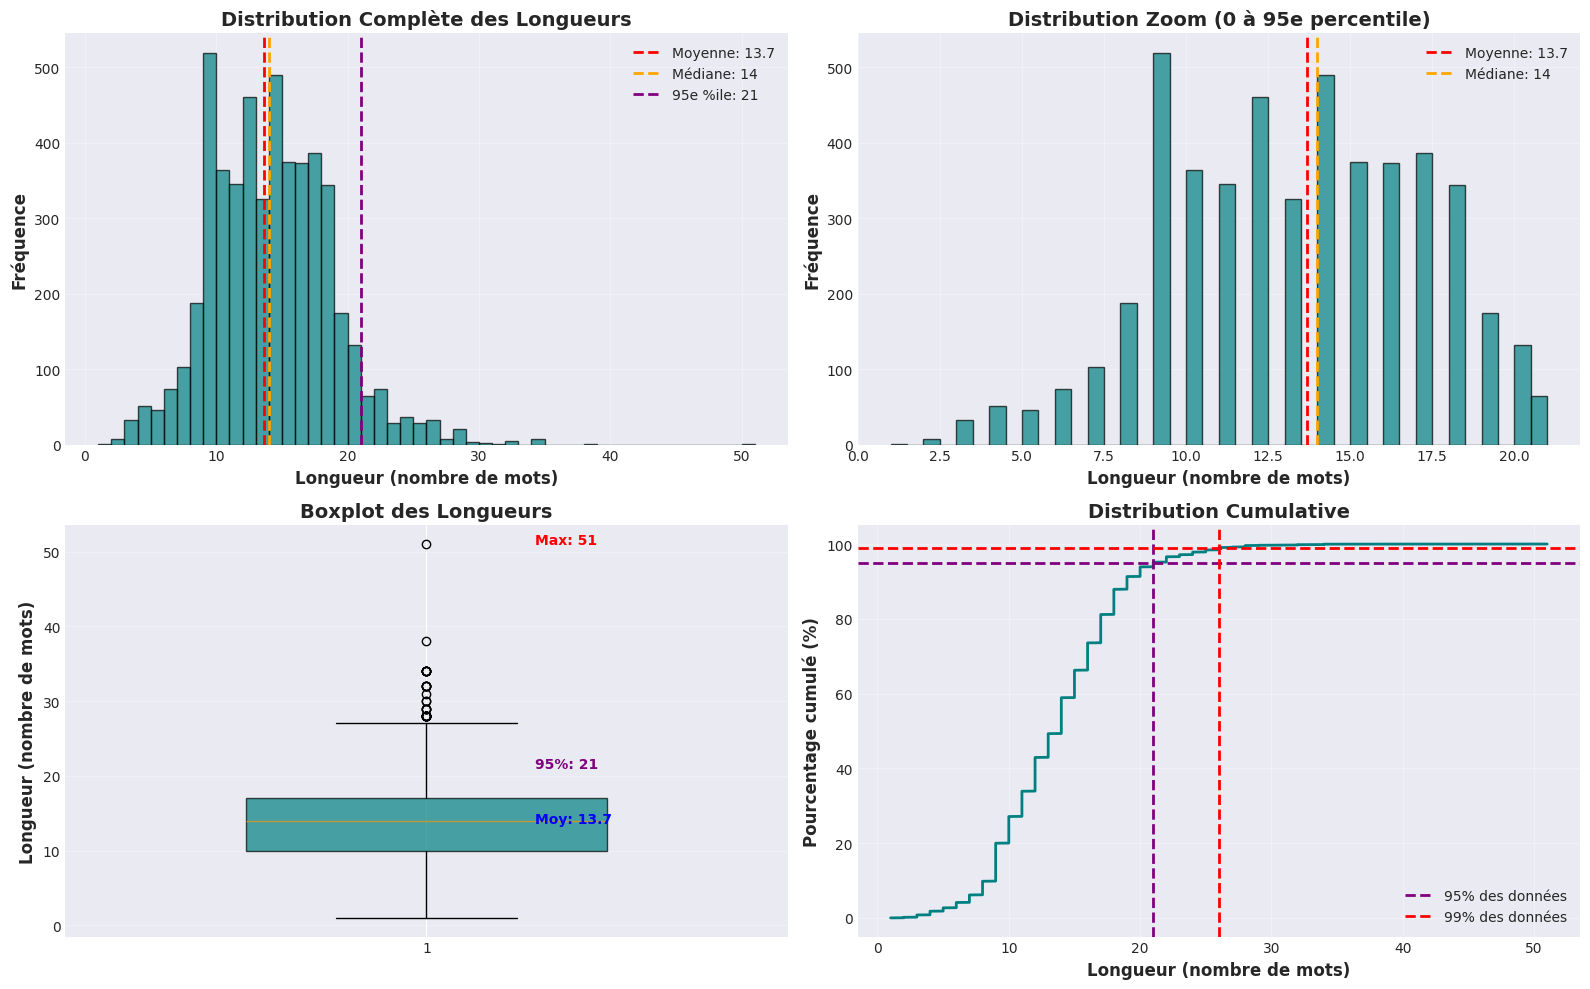


 IMPACT DU CHOIX DE MAX_LEN
Avec MAX_LEN actuel (46): 1 titres tronqués (0.0%)
Avec MAX_LEN = 95e percentile (21): 248 titres tronqués (4.9%)
Avec MAX_LEN = 99e percentile (26): 48 titres tronqués (0.9%)
Avec MAX_LEN = maximum (51): 0 titres tronqués (0%)

 RECOMMANDATION:
   • MAX_LEN = 51 capture 100% des données
   • MAX_LEN = 26 capture 99% des données (bon compromis)
   • MAX_LEN = 21 capture 95% des données (plus efficace)

     Attention: Un MAX_LEN trop grand peut augmenter le temps d'entraînement et le risque d'overfitting
    Recommandé: Utiliser le 95e ou 99e percentile plutôt que le maximum


In [64]:
# Calculer la longueur en mots de chaque titre enrichi
all_enriched_lengths = [len(str(text).split()) for text in X_enriched_all]

# Statistiques détaillées
max_len_enriched = max(all_enriched_lengths)
min_len_enriched = min(all_enriched_lengths)
mean_len_enriched = np.mean(all_enriched_lengths)
median_len_enriched = np.median(all_enriched_lengths)
percentile_95 = np.percentile(all_enriched_lengths, 95)
percentile_99 = np.percentile(all_enriched_lengths, 99)

print(" STATISTIQUES DE LONGUEUR DES TITRES ENRICHIS")
print("=" * 70)
print(f"Longueur minimale:    {min_len_enriched} mots")
print(f"Longueur moyenne:     {mean_len_enriched:.1f} mots")
print(f"Longueur médiane:     {median_len_enriched:.0f} mots")
print(f"95e percentile:       {percentile_95:.0f} mots")
print(f"99e percentile:       {percentile_99:.0f} mots")
print(f"Longueur maximale:    {max_len_enriched} mots")
print("=" * 70)

# Visualisation de la distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histogramme complet
ax1 = axes[0, 0]
ax1.hist(all_enriched_lengths, bins=50, edgecolor='black', alpha=0.7, color='teal')
ax1.axvline(mean_len_enriched, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_len_enriched:.1f}')
ax1.axvline(median_len_enriched, color='orange', linestyle='--', linewidth=2, label=f'Médiane: {median_len_enriched:.0f}')
ax1.axvline(percentile_95, color='purple', linestyle='--', linewidth=2, label=f'95e %ile: {percentile_95:.0f}')
ax1.set_xlabel('Longueur (nombre de mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution Complète des Longueurs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Zoom sur la partie principale (0 à 95e percentile)
ax2 = axes[0, 1]
filtered_lengths = [l for l in all_enriched_lengths if l <= percentile_95]
ax2.hist(filtered_lengths, bins=40, edgecolor='black', alpha=0.7, color='teal')
ax2.axvline(mean_len_enriched, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {mean_len_enriched:.1f}')
ax2.axvline(median_len_enriched, color='orange', linestyle='--', linewidth=2, label=f'Médiane: {median_len_enriched:.0f}')
ax2.set_xlabel('Longueur (nombre de mots)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax2.set_title('Distribution Zoom (0 à 95e percentile)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Boxplot
ax3 = axes[1, 0]
bp = ax3.boxplot(all_enriched_lengths, vert=True, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('teal')
bp['boxes'][0].set_alpha(0.7)
ax3.set_ylabel('Longueur (nombre de mots)', fontsize=12, fontweight='bold')
ax3.set_title('Boxplot des Longueurs', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# Ajouter les valeurs importantes
ax3.text(1.15, max_len_enriched, f'Max: {max_len_enriched}', fontsize=10, fontweight='bold', color='red')
ax3.text(1.15, percentile_95, f'95%: {percentile_95:.0f}', fontsize=10, fontweight='bold', color='purple')
ax3.text(1.15, mean_len_enriched, f'Moy: {mean_len_enriched:.1f}', fontsize=10, fontweight='bold', color='blue')

# 4. Courbe cumulative
ax4 = axes[1, 1]
sorted_lengths = sorted(all_enriched_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
ax4.plot(sorted_lengths, cumulative, linewidth=2, color='teal')
ax4.axhline(95, color='purple', linestyle='--', linewidth=2, label='95% des données')
ax4.axvline(percentile_95, color='purple', linestyle='--', linewidth=2)
ax4.axhline(99, color='red', linestyle='--', linewidth=2, label='99% des données')
ax4.axvline(percentile_99, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Longueur (nombre de mots)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Pourcentage cumulé (%)', fontsize=12, fontweight='bold')
ax4.set_title('Distribution Cumulative', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analyse des titres tronqués avec MAX_LEN actuel vs nouveau
current_max_len = 46
truncated_current = sum(1 for l in all_enriched_lengths if l > current_max_len)
truncated_new = sum(1 for l in all_enriched_lengths if l > max_len_enriched)

print(f"\n IMPACT DU CHOIX DE MAX_LEN")
print("=" * 70)
print(f"Avec MAX_LEN actuel ({current_max_len}): {truncated_current} titres tronqués ({truncated_current/len(all_enriched_lengths)*100:.1f}%)")
print(f"Avec MAX_LEN = 95e percentile ({int(percentile_95)}): {sum(1 for l in all_enriched_lengths if l > percentile_95)} titres tronqués ({sum(1 for l in all_enriched_lengths if l > percentile_95)/len(all_enriched_lengths)*100:.1f}%)")
print(f"Avec MAX_LEN = 99e percentile ({int(percentile_99)}): {sum(1 for l in all_enriched_lengths if l > percentile_99)} titres tronqués ({sum(1 for l in all_enriched_lengths if l > percentile_99)/len(all_enriched_lengths)*100:.1f}%)")
print(f"Avec MAX_LEN = maximum ({max_len_enriched}): {truncated_new} titres tronqués (0%)")
print("=" * 70)

print(f"\n RECOMMANDATION:")
print(f"   • MAX_LEN = {max_len_enriched} capture 100% des données")
print(f"   • MAX_LEN = {int(percentile_99)} capture 99% des données (bon compromis)")
print(f"   • MAX_LEN = {int(percentile_95)} capture 95% des données (plus efficace)")
print(f"\n     Attention: Un MAX_LEN trop grand peut augmenter le temps d'entraînement et le risque d'overfitting")
print(f"    Recommandé: Utiliser le 95e ou 99e percentile plutôt que le maximum")

## Définition du nouveau MAX_LEN optimal

In [65]:
# Utiliser le maximum pour capturer 100% des données
MAX_LEN_ENRICHED = max_len_enriched

print(f" Nouveau MAX_LEN défini: {MAX_LEN_ENRICHED} mots")
print(f"\n Ce choix permet de capturer 100% des données sans troncature")
print(f" Ancienne valeur: {MAX_LEN} mots")
print(f" Augmentation: +{MAX_LEN_ENRICHED - MAX_LEN} mots ({(MAX_LEN_ENRICHED - MAX_LEN) / MAX_LEN * 100:.1f}%)")

# Alternative recommandée (99e percentile pour efficacité)
MAX_LEN_99 = int(percentile_99)
print(f"\n Alternative (99e percentile): {MAX_LEN_99} mots")
print(f"   → Capture 99% des données avec moins de padding")
print(f"   → Seulement {sum(1 for l in all_enriched_lengths if l > MAX_LEN_99)} titres tronqués")

# Choisir la stratégie (décommenter celle voulue)
# Stratégie 1: Maximum (100% des données, plus de padding)
MAX_LEN_FINAL = MAX_LEN_ENRICHED

# Stratégie 2: 99e percentile (99% des données, moins de padding, plus efficace)
# MAX_LEN_FINAL = MAX_LEN_99

print(f"\n MAX_LEN choisi pour le modèle enrichi: {MAX_LEN_FINAL} mots")

 Nouveau MAX_LEN défini: 51 mots

 Ce choix permet de capturer 100% des données sans troncature
 Ancienne valeur: 46 mots
 Augmentation: +5 mots (10.9%)

 Alternative (99e percentile): 26 mots
   → Capture 99% des données avec moins de padding
   → Seulement 48 titres tronqués

 MAX_LEN choisi pour le modèle enrichi: 51 mots


## Tokenization pour LSTM (dataset enrichi)

In [66]:
# Configuration identique pour comparabilité
# MAX_WORDS et MAX_LEN déjà définis

# Tokenizer pour dataset enrichi
tokenizer_enriched = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer_enriched.fit_on_texts(X_enriched_train_text)

# Séquences enrichies
X_enriched_train_seq = tokenizer_enriched.texts_to_sequences(X_enriched_train_text)
X_enriched_val_seq = tokenizer_enriched.texts_to_sequences(X_enriched_val_text)
X_enriched_test_seq = tokenizer_enriched.texts_to_sequences(X_enriched_test_text)

# Padding enrichi
X_enriched_train_pad = pad_sequences(X_enriched_train_seq, maxlen=MAX_LEN_FINAL, padding='post')
X_enriched_val_pad = pad_sequences(X_enriched_val_seq, maxlen=MAX_LEN_FINAL, padding='post')
X_enriched_test_pad = pad_sequences(X_enriched_test_seq, maxlen=MAX_LEN_FINAL, padding='post')

print(f" Tokenization enrichie terminée !")
print(f"\n Shapes: Train {X_enriched_train_pad.shape}, Val {X_enriched_val_pad.shape}, Test {X_enriched_test_pad.shape}")

 Tokenization enrichie terminée !

 Shapes: Train (2856, 51), Val (715, 51), Test (1531, 51)


## Architecture et Entraînement LSTM (dataset enrichi)

In [67]:
# Créer le modèle LSTM enrichi (architecture identique)
lstm_model_enriched = creer_modele_lstm(MAX_WORDS, MAX_LEN_FINAL)
lstm_model_enriched.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(" Modèle LSTM enrichi créé !\n")
lstm_model_enriched.summary()

 Modèle LSTM enrichi créé !



Model: "sequential_4"

 Layer (type)                     Output Shape                  Param # 

 embedding_4 (Embedding)          ?                         0 (unbuilt) 

 bidirectional_8 (Bidirectional)  ?                         0 (unbuilt) 

 dropout_12 (Dropout)             ?                                   0 

 bidirectional_9 (Bidirectional)  ?                         0 (unbuilt) 

 dropout_13 (Dropout)             ?                                   0 

 dense_8 (Dense)                  ?                         0 (unbuilt) 

 dropout_14 (Dropout)             ?                                   0 

 dense_9 (Dense)                  ?                         0 (unbuilt)

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Entraînement du modèle enrichi
early_stop_enriched = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print(" Entraînement LSTM enrichi...\n")
history_lstm_enriched = lstm_model_enriched.fit(
    X_enriched_train_pad, y_enriched_train,
    validation_data=(X_enriched_val_pad, y_enriched_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop_enriched],
    verbose=1
)

print("\n Entraînement LSTM enrichi terminé !")

 Entraînement LSTM enrichi...

Epoch 1/10
45/45  7s 83ms/step - accuracy: 0.1956 - loss: 2.2664 - val_accuracy: 0.4042 - val_loss: 1.7246
Epoch 2/10
45/45  7s 83ms/step - accuracy: 0.1956 - loss: 2.2664 - val_accuracy: 0.4042 - val_loss: 1.7246
Epoch 2/10
45/45  3s 73ms/step - accuracy: 0.4676 - loss: 1.5736 - val_accuracy: 0.6839 - val_loss: 1.0094
Epoch 3/10
45/45  3s 73ms/step - accuracy: 0.4676 - loss: 1.5736 - val_accuracy: 0.6839 - val_loss: 1.0094
Epoch 3/10
45/45  3s 73ms/step - accuracy: 0.7290 - loss: 0.8788 - val_accuracy: 0.8042 - val_loss: 0.7374
Epoch 4/10
45/45  3s 73ms/step - accuracy: 0.7290 - loss: 0.8788 - val_accuracy: 0.8042 - val_loss: 0.7374
Epoch 4/10
45/45  3s 70ms/step - accuracy: 0.8578 - loss: 0.5254 - val_accuracy: 0.8140 - val_loss: 0.7908
Epoch 5/10
45/45  3s 70ms/step - accuracy: 0.8578 - loss: 0.5254 - val_accuracy: 0.8140 - val_loss: 0.7908
Epoch 5/10
45/45  3s 73ms/step - accuracy: 0.8955 - loss: 0.3846 - val_accuracy: 0.8462 - val_loss: 0.6908
Epoch 

## Évaluation LSTM (dataset enrichi)

In [69]:
# Évaluation du modèle enrichi
test_loss_enriched, test_acc_enriched = lstm_model_enriched.evaluate(X_enriched_test_pad, y_enriched_test, verbose=0)
y_pred_lstm_enriched = np.argmax(lstm_model_enriched.predict(X_enriched_test_pad, verbose=0), axis=1)

print("\n PERFORMANCES LSTM ENRICHI")
print("=" * 60)
print(f"Test Loss: {test_loss_enriched:.4f}")
print(f"Test Accuracy: {test_acc_enriched:.4f} ({test_acc_enriched*100:.2f}%)")
print("\n Classification Report:")
print(classification_report(y_enriched_test, y_pred_lstm_enriched, target_names=label_encoder.classes_))


 PERFORMANCES LSTM ENRICHI
Test Loss: 0.6785
Test Accuracy: 0.8556 (85.56%)

 Classification Report:
                        precision    recall  f1-score   support

Attractivité et emploi       0.93      1.00      0.97        42
          Cadre de vie       0.77      0.76      0.77       228
 Culture et patrimoine       0.62      0.81      0.70       102
 Education et jeunesse       0.92      0.95      0.93       421
         Environnement       0.92      0.90      0.91       291
             Mobilités       0.55      0.66      0.60        41
              Propreté       0.95      0.85      0.90        92
Prévention et sécurité       1.00      0.12      0.21        26
                 Santé       1.00      0.27      0.43        11
           Solidarités       0.92      0.86      0.89       177
                 Sport       0.83      0.88      0.85       100

              accuracy                           0.86      1531
             macro avg       0.86      0.73      0.74      1531


# Partie 3 : Comparaison des Performances

Dans cette section, nous comparons les performances du modèle LSTM entraîné sur le dataset standard versus le dataset enrichi.

## Tableau comparatif des métriques

In [70]:
# Créer un DataFrame comparatif
comparison_df = pd.DataFrame({
    'Modèle': ['LSTM Standard', 'LSTM Enrichi'],
    'Test Loss': [test_loss, test_loss_enriched],
    'Test Accuracy': [test_acc, test_acc_enriched],
    'Test Accuracy (%)': [test_acc * 100, test_acc_enriched * 100],
    'Amélioration (%)': [0, (test_acc_enriched - test_acc) * 100]
})

print("\n COMPARAISON DES PERFORMANCES")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Calcul de l'amélioration
improvement = (test_acc_enriched - test_acc) * 100
if improvement > 0:
    print(f"\n Le dataset enrichi améliore l'accuracy de {improvement:.2f} points de pourcentage!")
elif improvement < 0:
    print(f"\n  Le dataset enrichi diminue l'accuracy de {abs(improvement):.2f} points de pourcentage")
else:
    print(f"\n  Les deux datasets ont des performances identiques")


 COMPARAISON DES PERFORMANCES
       Modèle  Test Loss  Test Accuracy  Test Accuracy (%)  Amélioration (%)
LSTM Standard   1.244262       0.593464          59.346408          0.000000
 LSTM Enrichi   0.678509       0.855650          85.564989         26.218581

 Le dataset enrichi améliore l'accuracy de 26.22 points de pourcentage!


## Visualisation comparative

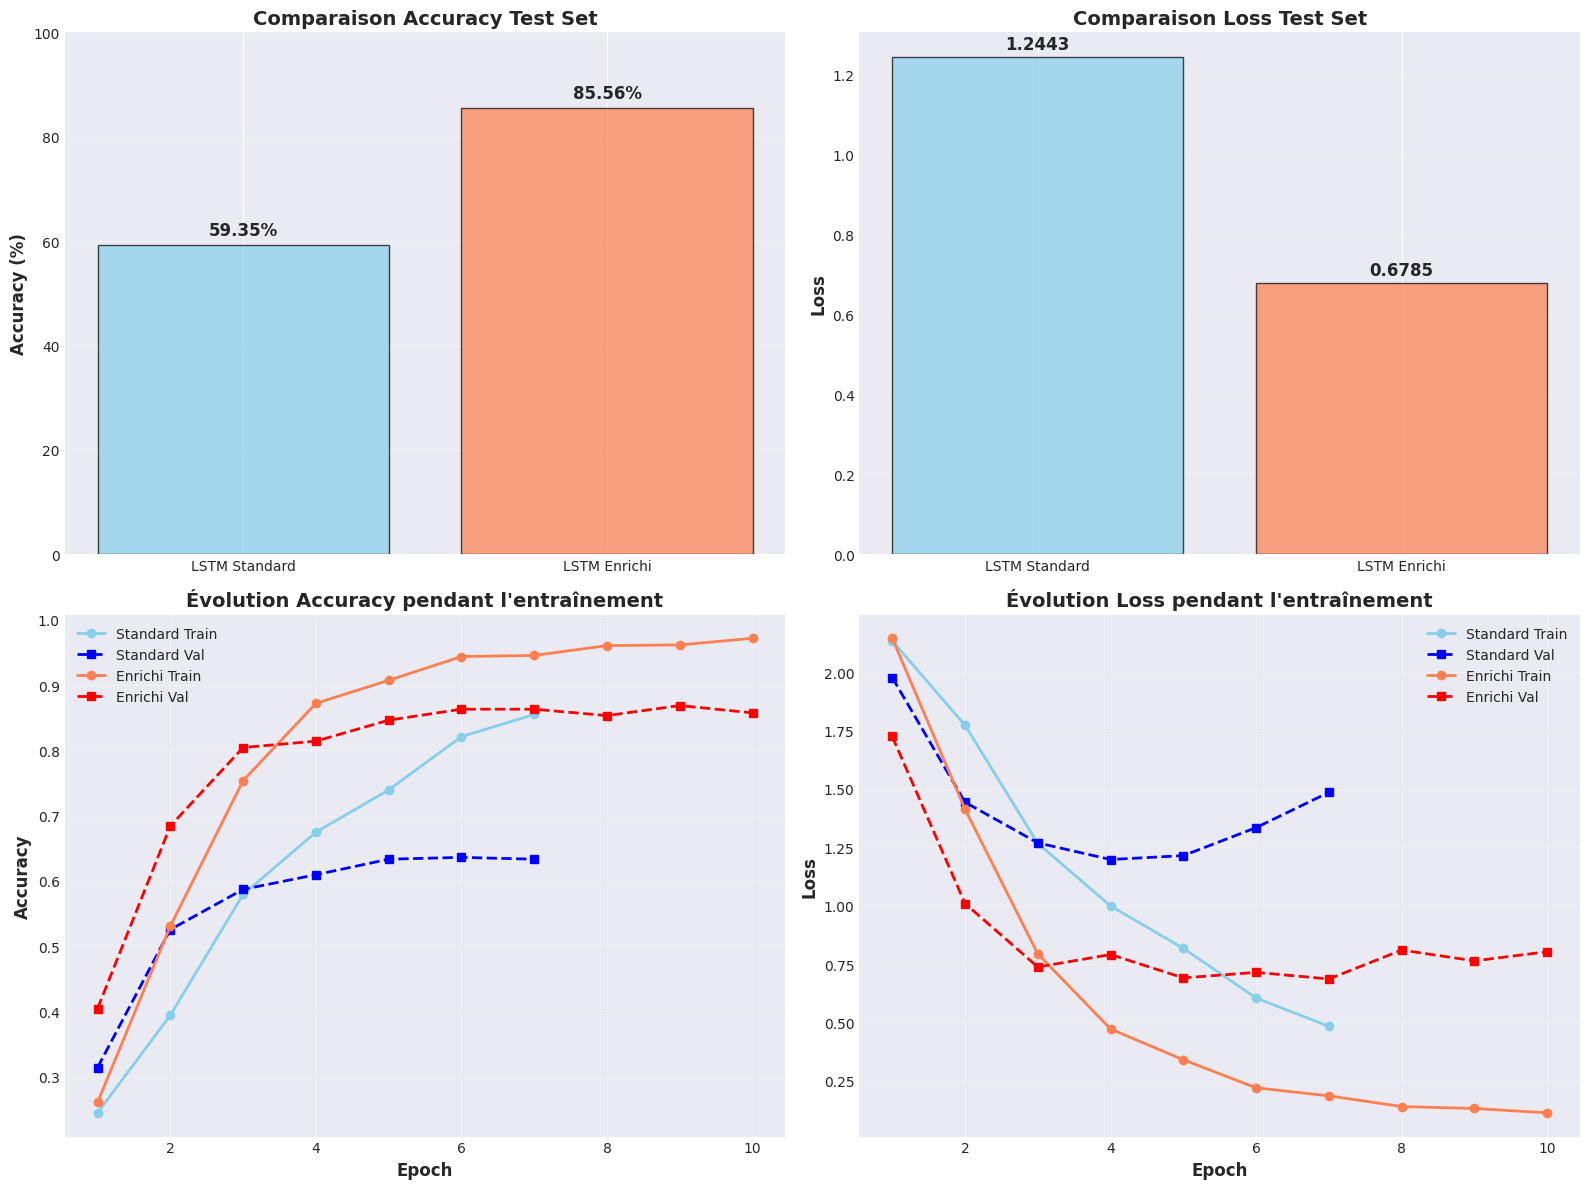

In [71]:
# Visualisation comparative des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparaison de l'accuracy sur test set
ax1 = axes[0, 0]
models = ['LSTM Standard', 'LSTM Enrichi']
accuracies = [test_acc * 100, test_acc_enriched * 100]
colors = ['skyblue', 'coral']
bars = ax1.bar(models, accuracies, color=colors, edgecolor='black', alpha=0.7)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison Accuracy Test Set', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Comparaison de la loss sur test set
ax2 = axes[0, 1]
losses = [test_loss, test_loss_enriched]
bars = ax2.bar(models, losses, color=colors, edgecolor='black', alpha=0.7)
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Comparaison Loss Test Set', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, loss in zip(bars, losses):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{loss:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Évolution de l'accuracy pendant l'entraînement
ax3 = axes[1, 0]
epochs_standard = range(1, len(history_lstm.history['accuracy']) + 1)
epochs_enriched = range(1, len(history_lstm_enriched.history['accuracy']) + 1)

ax3.plot(epochs_standard, history_lstm.history['accuracy'], 'o-', label='Standard Train', 
         color='skyblue', linewidth=2, markersize=6)
ax3.plot(epochs_standard, history_lstm.history['val_accuracy'], 's--', label='Standard Val', 
         color='blue', linewidth=2, markersize=6)
ax3.plot(epochs_enriched, history_lstm_enriched.history['accuracy'], 'o-', label='Enrichi Train', 
         color='coral', linewidth=2, markersize=6)
ax3.plot(epochs_enriched, history_lstm_enriched.history['val_accuracy'], 's--', label='Enrichi Val', 
         color='red', linewidth=2, markersize=6)

ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Évolution Accuracy pendant l\'entraînement', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# 4. Évolution de la loss pendant l'entraînement
ax4 = axes[1, 1]
ax4.plot(epochs_standard, history_lstm.history['loss'], 'o-', label='Standard Train', 
         color='skyblue', linewidth=2, markersize=6)
ax4.plot(epochs_standard, history_lstm.history['val_loss'], 's--', label='Standard Val', 
         color='blue', linewidth=2, markersize=6)
ax4.plot(epochs_enriched, history_lstm_enriched.history['loss'], 'o-', label='Enrichi Train', 
         color='coral', linewidth=2, markersize=6)
ax4.plot(epochs_enriched, history_lstm_enriched.history['val_loss'], 's--', label='Enrichi Val', 
         color='red', linewidth=2, markersize=6)

ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax4.set_title('Évolution Loss pendant l\'entraînement', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Analyse détaillée par classe

Comparaison des métriques (precision, recall, f1-score) pour chaque thématique entre les deux modèles.

In [72]:
# Obtenir les rapports de classification détaillés
from sklearn.metrics import precision_recall_fscore_support

# Calculer les métriques pour le modèle standard
precision_std, recall_std, f1_std, support_std = precision_recall_fscore_support(
    y_test, y_pred_lstm, average=None, labels=range(num_classes), zero_division=0
)

# Calculer les métriques pour le modèle enrichi
precision_enr, recall_enr, f1_enr, support_enr = precision_recall_fscore_support(
    y_enriched_test, y_pred_lstm_enriched, average=None, labels=range(num_classes), zero_division=0
)

# Créer un DataFrame pour comparer par thématique
class_comparison = pd.DataFrame({
    'Thématique': label_encoder.classes_,
    'Precision Std': precision_std,
    'Precision Enr': precision_enr,
    'Recall Std': recall_std,
    'Recall Enr': recall_enr,
    'F1 Std': f1_std,
    'F1 Enr': f1_enr,
    'Support': support_std
})

# Calculer les différences
class_comparison['Δ Precision'] = class_comparison['Precision Enr'] - class_comparison['Precision Std']
class_comparison['Δ Recall'] = class_comparison['Recall Enr'] - class_comparison['Recall Std']
class_comparison['Δ F1'] = class_comparison['F1 Enr'] - class_comparison['F1 Std']

# Trier par amélioration F1 (décroissant)
class_comparison_sorted = class_comparison.sort_values('Δ F1', ascending=False)

print("\n COMPARAISON PAR THÉMATIQUE (Top 10 améliorations)")
print("=" * 120)
print(class_comparison_sorted.head(10).to_string(index=False))

print("\n\n COMPARAISON PAR THÉMATIQUE (Top 10 détériorations)")
print("=" * 120)
print(class_comparison_sorted.tail(10).to_string(index=False))

# Calculer les moyennes
print("\n\n MOYENNES GLOBALES")
print("=" * 60)
print(f"Precision Standard: {precision_std.mean():.4f} | Enrichi: {precision_enr.mean():.4f} | Δ: {(precision_enr.mean() - precision_std.mean()):.4f}")
print(f"Recall Standard:    {recall_std.mean():.4f} | Enrichi: {recall_enr.mean():.4f} | Δ: {(recall_enr.mean() - recall_std.mean()):.4f}")
print(f"F1-Score Standard:  {f1_std.mean():.4f} | Enrichi: {f1_enr.mean():.4f} | Δ: {(f1_enr.mean() - f1_std.mean()):.4f}")


 COMPARAISON PAR THÉMATIQUE (Top 10 améliorations)
            Thématique  Precision Std  Precision Enr  Recall Std  Recall Enr   F1 Std   F1 Enr  Support  Δ Precision  Δ Recall     Δ F1
Attractivité et emploi       0.000000       0.933333    0.000000    1.000000 0.000000 0.965517       42     0.933333  1.000000 0.965517
 Culture et patrimoine       0.000000       0.619403    0.000000    0.813725 0.000000 0.703390      102     0.619403  0.813725 0.703390
                 Sport       0.245614       0.830189    0.140000    0.880000 0.178344 0.854369      100     0.584575  0.740000 0.676025
             Mobilités       0.000000       0.551020    0.000000    0.658537 0.000000 0.600000       41     0.551020  0.658537 0.600000
                 Santé       0.000000       1.000000    0.000000    0.272727 0.000000 0.428571       11     1.000000  0.272727 0.428571
           Solidarités       0.376947       0.921212    0.683616    0.858757 0.485944 0.888889      177     0.544265  0.175141 0.402

## Conclusion de la comparaison

Cette section synthétise les résultats obtenus en comparant les deux approches.

In [73]:
print("\n" + "=" * 80)
print(" " * 25 + " SYNTHÈSE DE LA COMPARAISON")
print("=" * 80)

# Résumé des résultats
improvement_acc = (test_acc_enriched - test_acc) * 100
improvement_loss = test_loss - test_loss_enriched

print(f"\n1⃣  PERFORMANCE GLOBALE:")
print(f"   • Dataset Standard:  Accuracy = {test_acc*100:.2f}%, Loss = {test_loss:.4f}")
print(f"   • Dataset Enrichi:   Accuracy = {test_acc_enriched*100:.2f}%, Loss = {test_loss_enriched:.4f}")
print(f"   • Amélioration:      {improvement_acc:+.2f} points de % (accuracy)")

if improvement_acc > 0:
    verdict = " Le dataset enrichi AMÉLIORE les performances"
elif improvement_acc < 0:
    verdict = "  Le dataset enrichi DÉGRADE les performances"
else:
    verdict = "  Les deux datasets ont des performances IDENTIQUES"

print(f"\n2⃣  VERDICT: {verdict}")

# Analyse des longueurs moyennes
print(f"\n3⃣  ANALYSE DES DONNÉES:")
print(f"   • Longueur moyenne (Standard): {np.mean(train_lengths):.1f} mots")
print(f"   • Longueur moyenne (Enrichi):  {np.mean(train_enriched_lengths):.1f} mots")
print(f"   • Différence:                  {np.mean(train_enriched_lengths) - np.mean(train_lengths):+.1f} mots")

# Compter combien de classes se sont améliorées
improved_classes = (class_comparison['Δ F1'] > 0).sum()
degraded_classes = (class_comparison['Δ F1'] < 0).sum()
unchanged_classes = (class_comparison['Δ F1'] == 0).sum()

print(f"\n4⃣  IMPACT PAR THÉMATIQUE:")
print(f"   • Thématiques améliorées:   {improved_classes}/{num_classes}")
print(f"   • Thématiques dégradées:    {degraded_classes}/{num_classes}")
print(f"   • Thématiques inchangées:   {unchanged_classes}/{num_classes}")

print("\n" + "=" * 80)

if improvement_acc > 1:
    print("\n RECOMMANDATION: Utiliser le dataset enrichi en production")
elif improvement_acc < -1:
    print("\n RECOMMANDATION: Conserver le dataset standard en production")
else:
    print("\n RECOMMANDATION: Les deux datasets sont équivalents, privilégier la simplicité")

print("=" * 80)


                          SYNTHÈSE DE LA COMPARAISON

1⃣  PERFORMANCE GLOBALE:
   • Dataset Standard:  Accuracy = 59.35%, Loss = 1.2443
   • Dataset Enrichi:   Accuracy = 85.56%, Loss = 0.6785
   • Amélioration:      +26.22 points de % (accuracy)

2⃣  VERDICT:  Le dataset enrichi AMÉLIORE les performances

3⃣  ANALYSE DES DONNÉES:
   • Longueur moyenne (Standard): 6.9 mots
   • Longueur moyenne (Enrichi):  13.7 mots
   • Différence:                  +6.7 mots

4⃣  IMPACT PAR THÉMATIQUE:
   • Thématiques améliorées:   11/11
   • Thématiques dégradées:    0/11
   • Thématiques inchangées:   0/11


 RECOMMANDATION: Utiliser le dataset enrichi en production


In [74]:
import os

print(" Sauvegarde du modèle LSTM enrichi...\n")

# 1. Sauvegarder le modèle au format .keras
model_keras_path = 'model/lstm2/lstm-titles-budgets-participatif.keras'
lstm_model_enriched.save(model_keras_path)
print(f" Modèle sauvegardé : {model_keras_path}")
print(f"   Taille du fichier : {os.path.getsize(model_keras_path) / (1024**2):.1f} MB")

# 2. Sauvegarder aussi au format h5 (legacy)
model_h5_path = 'model/lstm2/lstm-titles-budgets-participatif.h5'
lstm_model_enriched.save(model_h5_path)
print(f"\n Modèle également sauvegardé en .h5 : {model_h5_path}")
print(f"   Taille du fichier : {os.path.getsize(model_h5_path) / (1024**2):.1f} MB")

# 3. Sauvegarder le tokenizer enrichi
tokenizer_pickle_path = 'model/lstm2/lstm_titles_tokenizer.pickle'
with open(tokenizer_pickle_path, 'wb') as handle:
    pickle.dump(tokenizer_enriched, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"\n Tokenizer sauvegardé : {tokenizer_pickle_path}")
print(f"   Taille du fichier : {os.path.getsize(tokenizer_pickle_path) / (1024**2):.3f} MB")

# 4. Sauvegarder le mapping des labels
label_mapping_path = 'model/lstm2/lstm_titles_label_mapping.json'
mapping_dict = {int(i): str(label) for i, label in enumerate(label_encoder.classes_)}
reverse_mapping = {str(label): int(i) for i, label in enumerate(label_encoder.classes_)}

with open(label_mapping_path, 'w', encoding='utf-8') as f:
    json.dump({
        'num_to_label': mapping_dict,
        'label_to_num': reverse_mapping,
        'num_classes': num_classes
    }, f, ensure_ascii=False, indent=2)
print(f"\n Label mapping sauvegardé : {label_mapping_path}")
print(f"   Taille du fichier : {os.path.getsize(label_mapping_path) / 1024:.2f} KB")

print("\n" + "=" * 80)
print(" Tous les fichiers ont été sauvegardés avec succès dans model/lstm2/ !")
print("=" * 80)

 Sauvegarde du modèle LSTM enrichi...

 Modèle sauvegardé : model/lstm2/lstm-titles-budgets-participatif.keras
   Taille du fichier : 17.1 MB

 Modèle également sauvegardé en .h5 : model/lstm2/lstm-titles-budgets-participatif.h5
   Taille du fichier : 17.1 MB

 Tokenizer sauvegardé : model/lstm2/lstm_titles_tokenizer.pickle
   Taille du fichier : 0.151 MB

 Label mapping sauvegardé : model/lstm2/lstm_titles_label_mapping.json
   Taille du fichier : 0.64 KB

 Tous les fichiers ont été sauvegardés avec succès dans model/lstm2/ !

 Modèle également sauvegardé en .h5 : model/lstm2/lstm-titles-budgets-participatif.h5
   Taille du fichier : 17.1 MB

 Tokenizer sauvegardé : model/lstm2/lstm_titles_tokenizer.pickle
   Taille du fichier : 0.151 MB

 Label mapping sauvegardé : model/lstm2/lstm_titles_label_mapping.json
   Taille du fichier : 0.64 KB

 Tous les fichiers ont été sauvegardés avec succès dans model/lstm2/ !


In [75]:
print(" Chargement du modèle sauvegardé...\n")

# Charger le modèle
loaded_lstm_model = keras.models.load_model(model_keras_path)

print(" Modèle chargé avec succès !\n")

# Vérifier que le modèle chargé donne les mêmes prédictions
print(" Vérification de l'intégrité...")

# Prendre des exemples de test
test_sample = X_enriched_test_pad[:5]  # Prendre 5 exemples
test_texts = X_enriched_test_text[:5]  # Textes correspondants
test_labels = y_enriched_test[:5]  # Vraies étiquettes

# Prédictions avec le modèle original
pred_original = lstm_model_enriched.predict(test_sample, verbose=0)
pred_original_classes = np.argmax(pred_original, axis=1)

# Prédictions avec le modèle chargé
pred_loaded = loaded_lstm_model.predict(test_sample, verbose=0)
pred_loaded_classes = np.argmax(pred_loaded, axis=1)

# Affichage détaillé avec les thématiques
print("\n" + "=" * 90)
print(" " * 25 + " COMPARAISON DES PRÉDICTIONS")
print("=" * 90)

for i, (text, true_label, orig_pred, loaded_pred) in enumerate(
    zip(test_texts, test_labels, pred_original_classes, pred_loaded_classes), 1
):
    true_thematic = label_encoder.inverse_transform([true_label])[0]
    orig_thematic = label_encoder.inverse_transform([orig_pred])[0]
    loaded_thematic = label_encoder.inverse_transform([loaded_pred])[0]
    
    print(f"\n{i}. Titre: \"{text}\"")
    print(f"    Vraie thématique: {true_thematic}")
    print(f"    Modèle original: {orig_thematic} (confiance: {pred_original[i-1][orig_pred]*100:.1f}%)")
    print(f"   🟢 Modèle chargé: {loaded_thematic} (confiance: {pred_loaded[i-1][loaded_pred]*100:.1f}%)")
    
    if orig_pred == loaded_pred:
        print(f"    Prédictions identiques!")
    else:
        print(f"     Prédictions différentes!")

print("\n" + "=" * 90)

# Vérification numérique
if np.allclose(pred_original, pred_loaded, rtol=1e-5):
    print("\n Les prédictions numériques sont identiques - Le modèle a été correctement sauvegardé et chargé !")
else:
    print("\n  Différence détectée dans les prédictions numériques.")
    
# Comparaison détaillée
diff = np.abs(pred_original - pred_loaded)
print(f"\n Différence maximale : {diff.max():.2e}")
print(f"   Différence moyenne  : {diff.mean():.2e}")

 Chargement du modèle sauvegardé...

 Modèle chargé avec succès !

 Vérification de l'intégrité...
 Modèle chargé avec succès !

 Vérification de l'intégrité...

                          COMPARAISON DES PRÉDICTIONS

1. Titre: "trier ses déchets au plus près colonnes à verre enterrée rue des portes blanches e"
    Vraie thématique: Propreté
    Modèle original: Propreté (confiance: 99.7%)
   🟢 Modèle chargé: Propreté (confiance: 99.7%)
    Prédictions identiques!

2. Titre: "des cours d'école plus ludiques et vertes rénover et aménager la cour de l'em général lasalle"
    Vraie thématique: Education et jeunesse
    Modèle original: Education et jeunesse (confiance: 99.6%)
   🟢 Modèle chargé: Education et jeunesse (confiance: 99.6%)
    Prédictions identiques!

3. Titre: "de commerces dans les quartiers populaires alimentation generale"
    Vraie thématique: Attractivité et emploi
    Modèle original: Attractivité et emploi (confiance: 94.2%)
   🟢 Modèle chargé: Attractivité et emploi (